In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os, re
import cv2
import glob
from glob import glob
import pathlib
from IPython import display
import PIL
from PIL import Image

import math
import albumentations
import skimage
from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from keras.models import Model
from keras import backend as K
from keras.layers import Input, merge, Conv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda
from keras.layers.advanced_activations import ELU, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras.layers.noise import GaussianDropout

from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

# 1. Semantic_Segmentation

## (1) 시맨틱 세그멘테이션 데이터셋

### 1) 데이터 로더(data loader) 만들기

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(          # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370), w2h_ratio=370/1242, height=224, width=224, p=0.5),
                        Resize(width=224, height=224)])   # 입력이미지를 224X224로 resize
    return Compose([Resize(width=224, height=224)])       # 테스트용 데이터일 경우에는 224X224로 resize만 수행

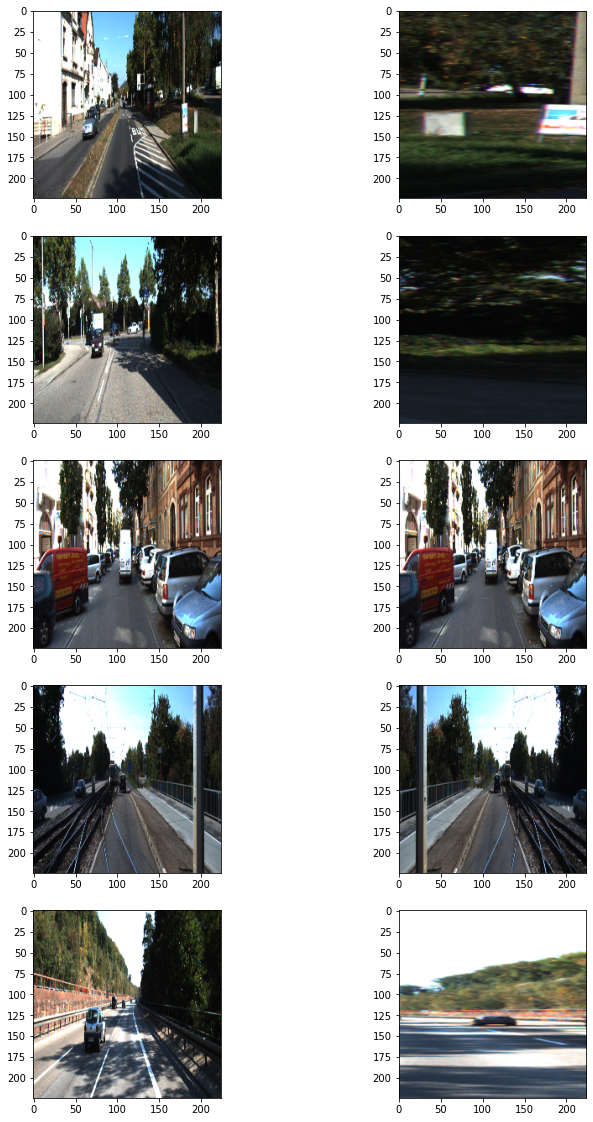

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용 
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])    # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=8,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input, "mask": _output}
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(dir_path, augmentation=augmentation)
test_generator = KittiGenerator(dir_path, augmentation=test_preproc, is_train=False)

## (2) 시맨틱 세그멘테이션 모델

### 1) 모델 구조 만들기

In [6]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [7]:
model = build_model(input_shape=(224, 224, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### 2) 모델 학습하기

In [8]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(train_generator, validation_data=test_generator,
          steps_per_epoch=len(train_generator), epochs=100)

model.save(model_path)

Epoch 1/100
22/22 [==============================] - 24s 497ms/step - loss: 0.6018 - val_loss: 0.2771
Epoch 2/100
22/22 [==============================] - 11s 477ms/step - loss: 0.0761 - val_loss: 0.0607
Epoch 3/100
22/22 [==============================] - 10s 473ms/step - loss: 0.0523 - val_loss: 0.0577
Epoch 4/100
22/22 [==============================] - 10s 469ms/step - loss: 0.0556 - val_loss: 0.0575
Epoch 5/100
22/22 [==============================] - 10s 463ms/step - loss: 0.0488 - val_loss: 0.0902
Epoch 6/100
22/22 [==============================] - 10s 463ms/step - loss: 0.0584 - val_loss: 0.0523
Epoch 7/100
22/22 [==============================] - 10s 462ms/step - loss: 0.0532 - val_loss: 0.0708
Epoch 8/100
22/22 [==============================] - 10s 463ms/step - loss: 0.0528 - val_loss: 0.0421
Epoch 9/100
22/22 [==============================] - 10s 464ms/step - loss: 0.0413 - val_loss: 0.0361
Epoch 10/100
22/22 [==============================] - 10s 468ms/step - loss: 0.041

## (3) 시맨틱 세그멘테이션 모델 시각화

In [9]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = tf.keras.models.load_model(model_path)

In [10]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

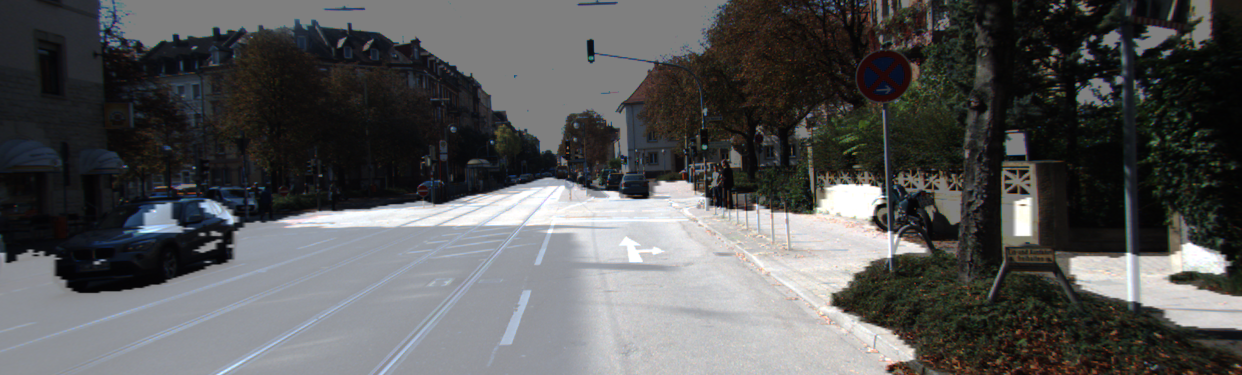

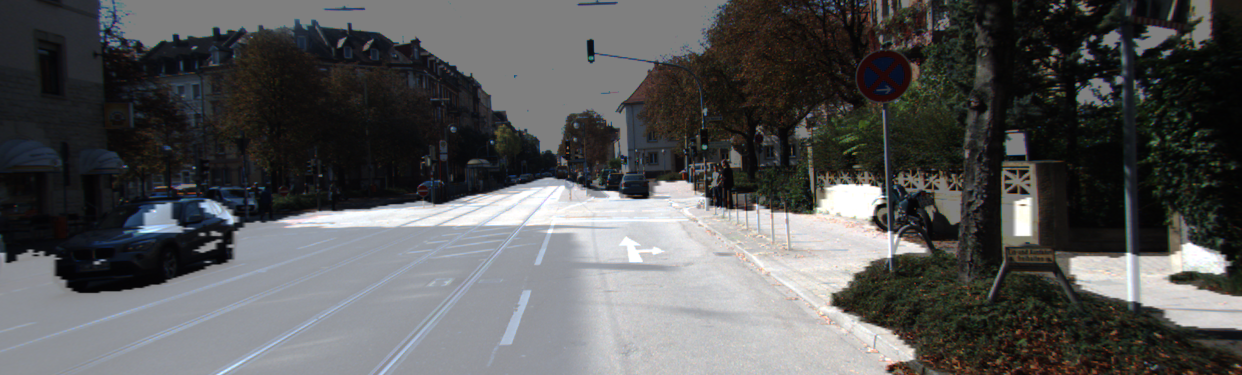

In [11]:
i = 1
get_output(
     model, test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png')

In [12]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [13]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()             # 도로로 판단한 영역을 시각화
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1  # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

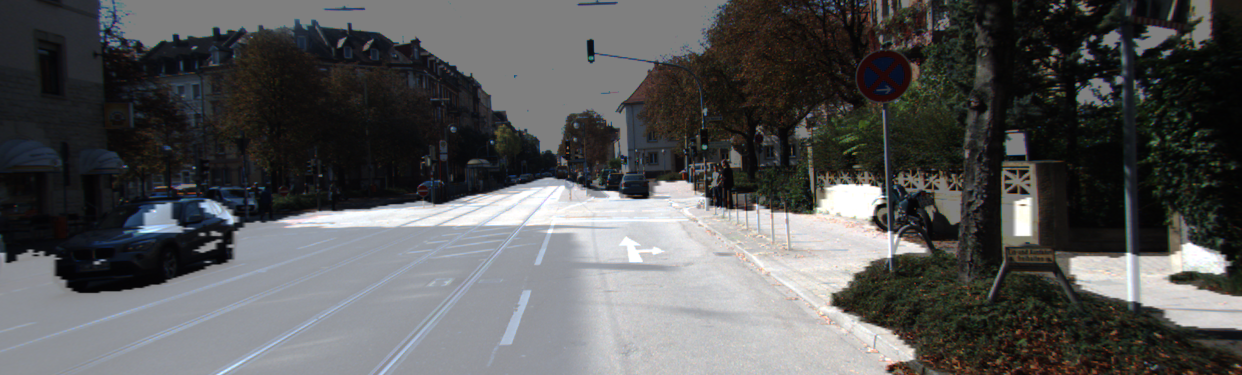

IoU : 0.788415


0.7884145194658642

In [14]:
i = 1
output, prediction, target = get_output(
     model, test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png')

calculate_iou_score(target, prediction)

# 2. Project_개선된 U-Net 모델 만들기
U-Net++

## (1) KITTI 데이터셋 수집과 구축

### 1) 데이터 로더(data loader) 만들기

In [15]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:
        return Compose([
                        HorizontalFlip(p=0.5),
                        RandomSizedCrop(min_max_height=(300, 370), w2h_ratio=370/1242, height=224, width=224, p=0.5),
                        Resize(width=224, height=224)])
    return Compose([Resize(width=224, height=224)])

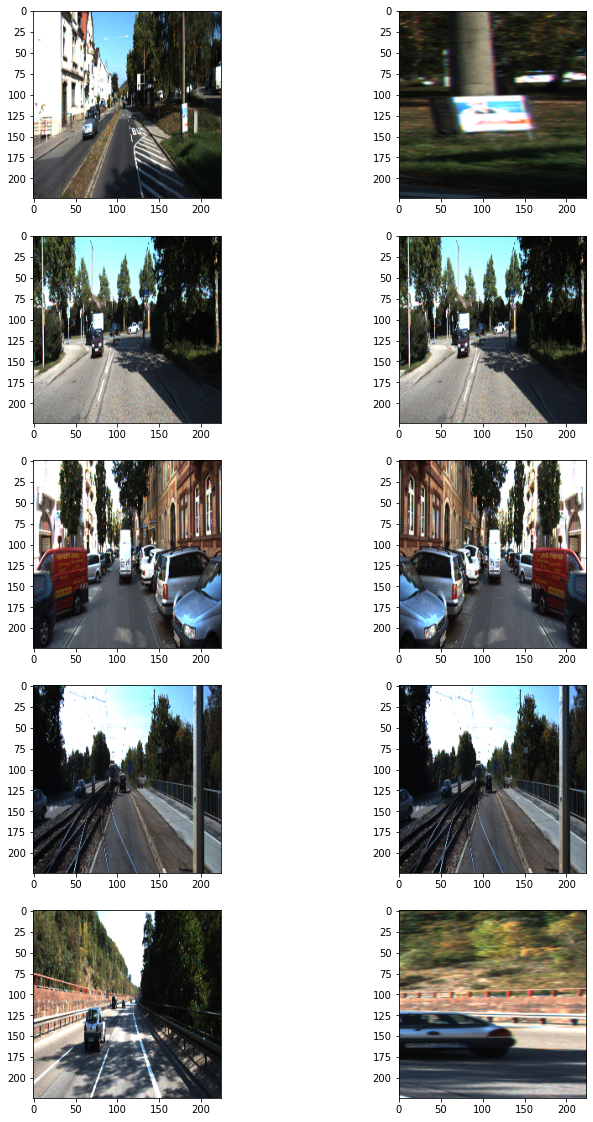

In [16]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"]) 
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])
  
plt.show()

In [17]:
class KittiGenerator(tf.keras.utils.Sequence):

    def __init__(self, 
                 dir_path,
                 batch_size=4,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[index*self.batch_size:
                           (index + 1)*self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input, "mask": _output}
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [18]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(dir_path, augmentation=augmentation)
test_generator = KittiGenerator(dir_path, augmentation=test_preproc, is_train=False)

## (2) U-Net++ 모델의 구현

### 1) 모델 구조 만들기

In [19]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):
    act = 'elu'
    dropout_rate = 0.4
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)
    return x

def UNet_PlusPlus(input_shape=(224, 224, 3), num_class=1, deep_supervision=False):
    nb_filter = [64,128,256,512,1024]
    img_input = Input(input_shape, name='main_input')
    
    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)
    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)
    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=3)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])
    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)
    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=3)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])
    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=3)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])
    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)
    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])
    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=3)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])
    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=3)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])
    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])
    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])
    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])
    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=3)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])
    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=3)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])
    
    nesnet_output_1 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nesnet_output_2 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nesnet_output_3 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nesnet_output_4 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    
    if deep_supervision:
        model = Model(inputs=img_input, outputs=[nesnet_output_1,
                                                 nesnet_output_2,
                                                 nesnet_output_3,
                                                 nesnet_output_4])
    else:
        model = Model(inputs=img_input, outputs = [nesnet_output_4])   
    return model

In [20]:
model = UNet_PlusPlus(input_shape=(224,224,3))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 224, 224, 64) 1792        main_input[0][0]                 
__________________________________________________________________________________________________
dp11_1 (Dropout)                (None, 224, 224, 64) 0           conv11_1[0][0]                   
__________________________________________________________________________________________________
conv11_2 (Conv2D)               (None, 224, 224, 64) 36928       dp11_1[0][0]                     
____________________________________________________________________________________________

### 2) 모델 학습하기

In [21]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation'

model_unet_plusplus = UNet_PlusPlus()
model_unet_plusplus.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy')
model_unet_plusplus.fit(train_generator, validation_data=test_generator,
                        steps_per_epoch=len(train_generator), epochs=100)

model_path_unet_plusplus = dir_path + '/seg_model_unet_plusplus.h5'
model_unet_plusplus.save(model_path_unet_plusplus)

Epoch 1/100
43/43 [==============================] - 38s 606ms/step - loss: 1.8411 - val_loss: 2.0408
Epoch 2/100
43/43 [==============================] - 25s 583ms/step - loss: 1.5502 - val_loss: 2.3226
Epoch 3/100
43/43 [==============================] - 25s 573ms/step - loss: 1.4348 - val_loss: 2.6280
Epoch 4/100
43/43 [==============================] - 25s 581ms/step - loss: 1.3700 - val_loss: 1.6273
Epoch 5/100
43/43 [==============================] - 25s 582ms/step - loss: 1.2616 - val_loss: 1.8882
Epoch 6/100
43/43 [==============================] - 25s 579ms/step - loss: 1.2135 - val_loss: 1.3366
Epoch 7/100
43/43 [==============================] - 25s 580ms/step - loss: 1.1338 - val_loss: 1.8904
Epoch 8/100
43/43 [==============================] - 25s 581ms/step - loss: 1.0851 - val_loss: 1.4467
Epoch 9/100
43/43 [==============================] - 25s 581ms/step - loss: 1.0431 - val_loss: 1.6082
Epoch 10/100
43/43 [==============================] - 25s 582ms/step - loss: 0.984

## (3) U-Net과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

### 1) U-Net

In [31]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'
model_path = dir_path + '/seg_model_unet.h5'
model = tf.keras.models.load_model(model_path)

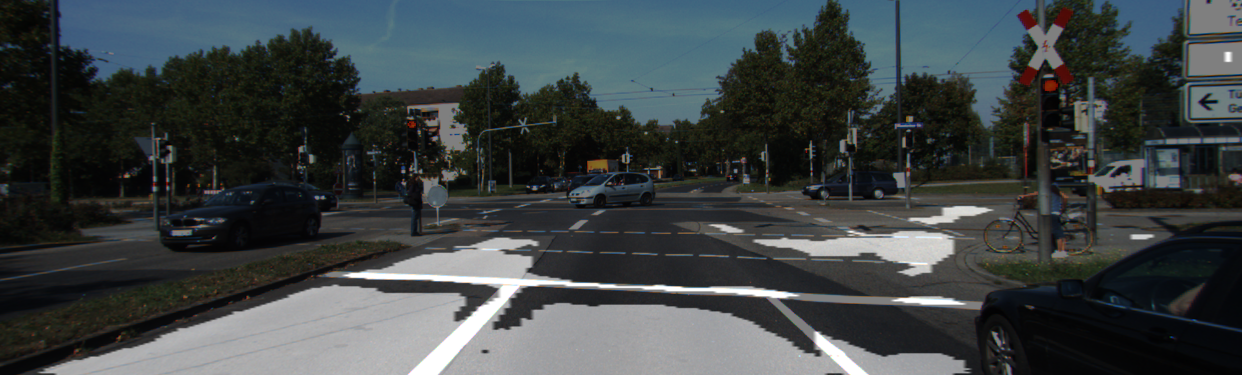

IoU : 0.427770


0.42776989552431316

In [32]:
i = 13
file_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

output, prediction, target = get_output(
     model, test_preproc,
     image_path=file_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=file_path + f'./result_{str(i).zfill(3)}.png',
     label_path=file_path + f'/semantic/00{str(i).zfill(4)}_10.png')

calculate_iou_score(target, prediction)

### 2) U-Net++

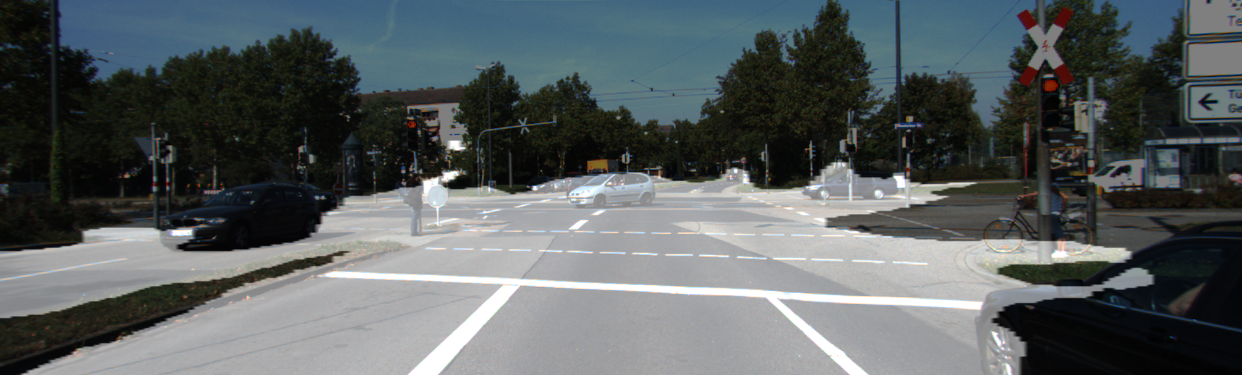

IoU : 0.777402


0.7774016763378465

In [30]:
i = 13

output, prediction, target = get_output(
     model_unet_plusplus, test_preproc,
     image_path=file_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=file_path + f'./result_{str(i).zfill(3)}.png',
     label_path=file_path + f'/semantic/00{str(i).zfill(4)}_10.png')

calculate_iou_score(target, prediction)

# 3. References

[1] https://lms.aiffel.io/course/405/node/476